In [1]:
# Install necessary packages
!pip install tensorflow matplotlib pillow --quiet


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input


In [ ]:
# Load and preprocess image
def preprocess_image(image_path, target_dim=(400, 400)):
    image = load_img(image_path, target_size=target_dim)
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    return preprocess_input(image)

In [ ]:
# Convert processed image back to displayable form
def restore_image(processed_img):
    img = processed_img.copy().reshape((400, 400, 3))
    img[:, :, 0] += 103.939
    img[:, :, 1] += 116.779
    img[:, :, 2] += 123.68
    img = img[:, :, ::-1]
    return np.clip(img, 0, 255).astype('uint8')

In [5]:
# Display image with title
def plot_image(img_tensor, title="Image"):
    display_img = restore_image(img_tensor)
    plt.imshow(display_img)
    plt.title(title)
    plt.axis('off')
    plt.show()

In [6]:
# Image paths
CONTENT_PATH = "content.jpg"
STYLE_PATH = "style.jpg"

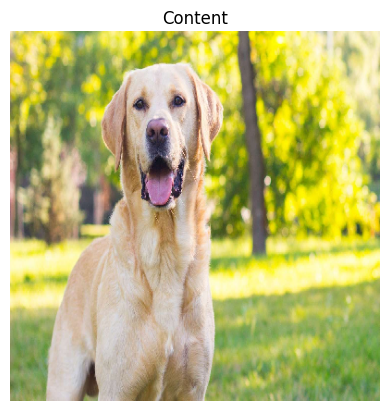

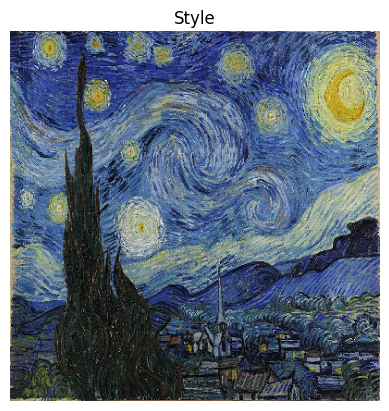

In [7]:
# Load content and style images
content_img = preprocess_image(CONTENT_PATH)
style_img = preprocess_image(STYLE_PATH)

plot_image(content_img, "Content")
plot_image(style_img, "Style")

In [8]:
# Load VGG19 model without the top classification layer
def build_vgg_model(layer_names):
    vgg = VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
    outputs = [vgg.get_layer(name).output for name in layer_names]
    return tf.keras.Model(inputs=vgg.input, outputs=outputs)


In [9]:
# Compute Gram Matrix for style representation
def calculate_gram_matrix(tensor):
    tensor = tf.squeeze(tensor)
    reshaped = tf.reshape(tensor, [-1, tensor.shape[-1]])
    n = tf.shape(reshaped)[0]
    return tf.matmul(reshaped, reshaped, transpose_a=True) / tf.cast(n, tf.float32)


In [10]:
# Define layers
STYLE_LAYERS = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']
CONTENT_LAYER = ['block5_conv2']
vgg_model = build_vgg_model(STYLE_LAYERS + CONTENT_LAYER)

In [11]:
# Extract target features
style_features = vgg_model(style_img)
content_features = vgg_model(content_img)
style_targets = [calculate_gram_matrix(feat) for feat in style_features[:len(STYLE_LAYERS)]]
content_target = [content_features[-1]]

In [12]:
# Define weights
STYLE_WEIGHT = 1e5
CONTENT_WEIGHT = 1e4

In [13]:
# Optimization setup
generated = tf.Variable(content_img, dtype=tf.float32)
optimizer = tf.optimizers.Adam(learning_rate=5.0)

In [14]:
# Loss function
def compute_total_loss(outputs, style_targets, content_target):
    style_outputs = outputs[:len(STYLE_LAYERS)]
    content_output = outputs[len(STYLE_LAYERS):]

    style_loss = tf.add_n([
        tf.reduce_mean(tf.square(calculate_gram_matrix(gen) - target))
        for gen, target in zip(style_outputs, style_targets)
    ])

    content_loss = tf.add_n([
        tf.reduce_mean(tf.square(gen - target))
        for gen, target in zip(content_output, content_target)
    ])

    total_loss = STYLE_WEIGHT * style_loss + CONTENT_WEIGHT * content_loss
    return total_loss


In [15]:
# Training step using GradientTape
@tf.function
def train_one_step(image):
    with tf.GradientTape() as tape:
        outputs = vgg_model(image)
        loss = compute_total_loss(outputs, style_targets, content_target)
    grads = tape.gradient(loss, image)
    optimizer.apply_gradients([(grads, image)])
    image.assign(tf.clip_by_value(image, 0.0, 255.0))

In [16]:
# Train model
EPOCHS = 50
for step in range(EPOCHS):
    train_one_step(generated)
    if step % 10 == 0:
        print(f"Training step {step} completed")

Training step 0 completed
Training step 10 completed
Training step 20 completed
Training step 30 completed
Training step 40 completed


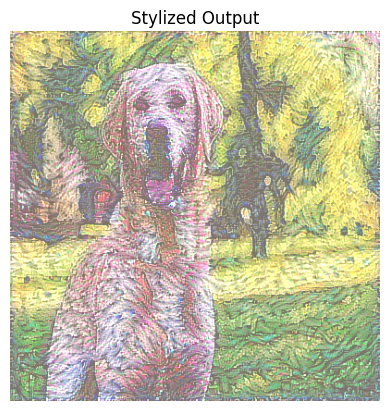

In [17]:
# Display final stylized image
stylized_output = generated.numpy()
plot_image(stylized_output, "Stylized Output")

In [18]:
# Save final output
output_img = Image.fromarray(restore_image(stylized_output))
output_img.save("stylized_output.jpg")
print("Stylized image saved as stylized_output.jpg")

Stylized image saved as stylized_output.jpg
